# scRNAseq downstream analysis

Based on Jupyter Notebook created by Lauren Sanders.


### Script: Zip all files for scanpy (optional):
- Run only when input files are not zipped yet. Otherwise loading AnnData will fail
- NOTE: input path is hardcoded

In [797]:
# Set the working folder:
root_folder = './test/'

In [798]:
# Define the file extensions we are looking for
extensions = ('.tsv', '.mtx')
#load libraries:
import os
import gzip
import shutil
# Function to find and zip files
def zipper(root_folder):
 
    # Walk through the directory, including subdirectories
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file is in a 'filtered' subdirectory:
            if 'filtered' in root:
                # Check for the desired file extension:
                if file.endswith(extensions):
                    file_path = os.path.join(root, file)
                    output_path = file_path + '.gz'  # Create the .gz filename
                    
                    # Zip the file:
                    with open(file_path, 'rb') as f_in:
                        with gzip.open(output_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    
                    print(f"Successfully zipped: {file_path} to {output_path}")
                else:
                    print(f"Skipping non-target file: {file}")
#execute the function:
zipper(root_folder)

Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\features.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\matrix.mtx to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered\matrix.mtx.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\barcodes.tsv.gz
Skipping non-target file: barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\features.tsv.gz
Skipping non-target file: features.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\matrix.mtx to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO1

### Script: prepare marker table for scoreCT (optional):
* Raw marker table from GeneLab is modified for scoreCT readable file format.
* NOTE: scoreCT accepts *.gmt which is tab separated matrix. This script properly converts GeneLab marker table.

In [201]:
# Load libraries:
import pandas as pd

# Load inputs:
df_input = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers.csv'
df_output = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.gmt'
column_name = 'cellName'
column_gene = 'geneSymbol'

# Load data:
df = pd.read_csv(df_input)
df = pd.DataFrame(df)

# Select only cellName and geneSymbol:
df_selected = df[[column_name, column_gene]]

# Create new columns for each representing gene:
df_split = df_selected[column_gene].str.split(',', expand=True)

# Concatenate the "one" column with the newly split columns
df_result = pd.concat([df[[column_name]], df_split], axis=1)

# Add the second column with "na" values
df_result.insert(1, 'na_column', 'na')

# Save results as tab-delimited file:
df_result.to_csv(df_output, sep='\t', header=False, index=False)


### Downstream analysis - chunk by chunk:
* Each codeblock is a separate script - I loaded libraries before function, because I copy the whole code to python scripts.
* To run whole analysis, simply run main.py

#### Module1: Structure.py
- Generate folder structure: plots and AnnData results

In [831]:
import os

def Structure():
    """
    Generate folder structure: plots and AnnData results
    """
    # Define folder names
    folders = ['plots', 'AnnData']
    
    # Create the folders if they don't exist
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)
            print(f"Folder '{folder}' created.")
        else:
            print(f"Folder '{folder}' already exists.")

#### Module2: parameters.py

In [722]:
"""
This script stores all necessary default parameters: 
"""

#Basic Filtering parameters:
DEFAULT_GENES_PERCENTILE = 5

DEFAULT_CELLS_PERCENTILE = 1

#Parameters to plot Genes and Cells:
save_format = "png"
save_dpi = 300
genes_plot = True
cells_plot = True

#Parameters for Violin plots etc:
jitter_param = 0.4

#filter cells based on gene counts (basic is 2500):
filter_gene_counts = 2500

#number of pcs in PCA plot:
n_pcs=40

#scoreCT parameters annotation:
null_model_param='multinomial'
cluster_key_param='leiden'

#### Module3: SaveData.py

In [832]:
import matplotlib.pyplot as plt  # Ensure this is imported

def SaveData(adata=None, genes_plot=None, cells_plot=None, mt_analysis=False, 
             genes_counts=None, total_counts=None, pct_counts_mt=None, 
             pct_mt_scatter=None, genes_counts_scatter=None, postNormplot = None, PCAplot=None, scoreCT_out=None, umap=None):
    """
    Function executes data saving from user defined preferences.
    By default, all parameters are empty and saving is not executed.

    By default, saving plot format is set to png and dpi is set to 300.
    It is possible to change parameters in parameters.py function.
    """
    # Create folders if they do not exist
    if not os.path.exists('AnnData'):
        os.makedirs('AnnData')
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
        
    if adata is not None:
        adata.write(f"AnnData/{sample_name}_filtered.h5ad")
        print(f"Filtered data saved to {sample_name}_filtered.h5ad")
    
    if genes_plot is not None:
        genes_plot.figure.savefig(f"plots/{sample_name}_genes_plot.{save_format}", dpi=save_dpi)
        print(f"Saved genes_plot plot as {sample_name}_genes_plot.{save_format}")

    if cells_plot is not None:
        cells_plot.figure.savefig(f"plots/{sample_name}_cells_plot.{save_format}", dpi=save_dpi)
        print(f"Saved cells_plot plot as {sample_name}_cells_plot.{save_format}")
        
    if genes_counts is not None:
        genes_counts.figure.savefig(f"plots/{sample_name}_violin_genes_counts.{save_format}", dpi=save_dpi)
        print(f"Saved genes_counts plot as {sample_name}_violin_genes_counts.{save_format}")

    if total_counts is not None:
        total_counts.figure.savefig(f"plots/{sample_name}_violin_total_counts.{save_format}", dpi=save_dpi)
        print(f"Saved total_counts plot as {sample_name}_violin_total_counts.{save_format}")

    if pct_counts_mt is not None:
        pct_counts_mt.figure.savefig(f"plots/{sample_name}_violin_pct_counts_mt.{save_format}", dpi=save_dpi)
        print(f"Saved pct_counts_mt plot as {sample_name}_violin_pct_counts_mt.{save_format}")

    if pct_mt_scatter is not None:
        pct_mt_scatter.figure.savefig(f"plots/{sample_name}_scatter_pct_mt.{save_format}", dpi=save_dpi)
        print(f"Saved pct_mt_scatter plot as {sample_name}_scatter_pct_mt.{save_format}")

    if genes_counts_scatter is not None:
        genes_counts_scatter.figure.savefig(f"plots/{sample_name}_scatter_genes_counts.{save_format}", dpi=save_dpi)
        print(f"Saved genes_counts_scatter plot as {sample_name}_scatter_genes_counts.{save_format}")

    if postNormplot is not None:
        postNormplot.figure.savefig(f"plots/{sample_name}_HighlyExpressedGenes.{save_format}", dpi=save_dpi)
        print(f"Saved HighlyExpressedGenes plot as {sample_name}_HighlyExpressedGenes.{save_format}")

    if PCAplot is not None:
        PCAplot.figure.savefig(f"plots/{sample_name}_PCAplot.{save_format}", dpi=save_dpi)
        print(f"Saved PCAplot plot as {sample_name}_PCAplot.{save_format}")

    if scoreCT_out is not None:
        scoreCT_out.write(f"AnnData/{sample_name}_annotated.h5ad")
        print(f"Annotated data saved to {sample_name}_annotated.h5ad")

    if umap is not None:
        umap.figure.savefig(f"plots/{sample_name}_UMAP.{save_format}", dpi=save_dpi)
        print(f"Saved UMAP plot as {sample_name}_UMAP.{save_format}")

#### Module4: BasicFiltering.py

In [577]:
import numpy as np
import scanpy as sc

def BasicFiltering(genes_percentile=None, cells_percentile=None, save_data=False):

    # Calculate QC metrics
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cdf = stat[0]
    gdf = stat[1]

    # Use user-specified percentiles or defaults
    genes_percentile = genes_percentile if genes_percentile is not None else DEFAULT_GENES_PERCENTILE
    cells_percentile = cells_percentile if cells_percentile is not None else DEFAULT_CELLS_PERCENTILE

    # Calculate thresholds
    genes = list(set(cdf['n_genes_by_counts']))
    cells = list(set(gdf['n_cells_by_counts']))

    gene_threshold = np.percentile(genes, genes_percentile)
    cell_threshold = np.percentile(cells, cells_percentile)

    # Save the thresholds in adata.uns
    adata.uns['gene_threshold'] = gene_threshold
    adata.uns['cell_threshold'] = cell_threshold
    
    print(f'Filter out cells expressing fewer than: {gene_threshold} genes ({genes_percentile}th percentile)')
    print(f'Filter out genes detected in fewer than: {cell_threshold} cells ({cells_percentile}th percentile)')

    # Save adata if requested
    if save_data:
        SaveData(adata=adata)
    return adata
    

#### Module5: plotCellsAndGenes.py
Plot 1 and 2: Distribution plot of genes vs cells and cells vs genes:

In [823]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

def plotCellsAndGenes(genes_plot=genes_plot, cells_plot=cells_plot, save_data=False):
  
    # Calculate QC metrics based on the filtered adata from BasicFiltering
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cell_qc_dataframe = stat[0]
    gene_qc_dataframe = stat[1]

    # Retrieve the filtering thresholds from the adata object after BasicFiltering
    gene_threshold = adata.uns.get('gene_threshold', None)
    cell_threshold = adata.uns.get('cell_threshold', None)
    
    if gene_threshold is None or cell_threshold is None:
        raise ValueError("Filtering thresholds not found in the adata object. Ensure BasicFiltering was run.")

    print(f'Gene threshold: {gene_threshold}')
    print(f'Cell threshold: {cell_threshold}')

    # Unique variables for plot data
    genes_plot_data = None
    cells_plot_data = None

    # Plot Number of Genes by Counts (only if genes_plot is True)
    if genes_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for genes plot
        ax.hist(cell_qc_dataframe['n_genes_by_counts'], bins="sqrt")
        ax.set(xlabel='N genes', ylabel='N cells')
        ax.axvline(gene_threshold, color='red')
        ax.set_title("Number of genes by counts")
        plt.show()
        genes_plot_data = fig  # Store figure for later use

    # Plot Number of Cells by Counts (only if cells_plot is True)
    if cells_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for cells plot
        ax.hist([int(x) for x in gene_qc_dataframe['n_cells_by_counts'] if x != 0], bins="sqrt")
        ax.set(xlabel='N cells expressing > 0', ylabel='N genes')
        ax.axvline(cell_threshold, color='red')
        ax.set_title("Number of cells by counts")
        plt.show()
        cells_plot_data = fig  # Store figure for later use
    
    if save_data:
        SaveData(genes_plot=genes_plot_data, cells_plot=cells_plot_data)
        print(f"Genes plot and Cells plot were saved!")
    

#### Module6: mtAnalysis.py
* Annotate mitochondrial genes (optional)

In [802]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mtAnalysis(analysis=True, save_mt=False):

    if analysis:
        # Check for common mitochondrial gene prefixes in the first 50 gene names
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                # Annotate mitochondrial genes as "mt"
                adata.var["mt"] = adata.var_names.str.startswith(prefix)
                break
            # Add flag to indicate mitochondrial analysis was performed
            adata.uns['mt_analysis'] = True
        
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")
            adata.var["mt"] = False  # No mitochondrial genes found

        # Calculate QC metrics including mitochondrial genes
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
        print(f"Annotated mitochondrial genes and calculated QC metrics.")
    else:
        # Perform QC metrics calculation without mitochondrial gene annotation
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        print(f"Calculated QC metrics.")

    # Freeze current state for saving
    adata_frozen = adata.copy()

    # Save data if requested
    if save_mt:
        SaveData(adata=adata_frozen, mt_analysis=True)

    return adata

#### Module7: plotViolinScatter.py
- title does not work

In [582]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotViolinScatter(genes_counts=True, total_counts=True, pct_counts_mt=True, pct_mt_scatter=True, genes_counts_scatter=True, save_data=False):

    plots_data = {}

    # Collect generated plots for saving
    genes_counts_fig = None
    total_counts_fig = None
    pct_counts_mt_fig = None
    pct_mt_scatter_fig = None
    genes_counts_scatter_fig = None
    
    # Violin plots
    if genes_counts:
        genes_counts_fig = sc.pl.violin(adata, "n_genes_by_counts", jitter=jitter_param, show=False)

    
    if total_counts:
        total_counts_fig = sc.pl.violin(adata, "total_counts", jitter=jitter_param, show=False)
       
    if pct_counts_mt:
        if "pct_counts_mt" in adata.obs:
            pct_counts_mt_fig = sc.pl.violin(adata, "pct_counts_mt", jitter=jitter_param, show=False)
           
    # Scatter plots
    if pct_mt_scatter:
        pct_mt_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
       
    if genes_counts_scatter:
        genes_counts_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
        
    # Save data if requested
    if save_data:
       SaveData(
           genes_counts=genes_counts_fig,
           total_counts=total_counts_fig,
           pct_counts_mt=pct_counts_mt_fig,
           pct_mt_scatter=pct_mt_scatter_fig,
           genes_counts_scatter=genes_counts_scatter_fig
       )

#### Module8: FilterCells.py

In [803]:
import scanpy as sc

def FilterCells():
    global adata

    # Check if 'mt_analysis' exists in adata.uns and is True
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Filter cells based on gene counts and mitochondrial content
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        adata = adata[adata.obs.pct_counts_mt < 5, :].copy()  # Assuming you want to filter out cells with more than 5% mitochondrial genes
        print(f"Filtered cells based on gene counts with mt_analysis.")
    else:
        # Filter cells based only on gene counts
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        print(f"Filtered cells based on gene counts.")

#### Module9: Normalization.py & RegressOut.py

In [647]:
import numpy as np
import scanpy as sc

def Normalization(adata):
    """
    Normalize and preprocess the AnnData object.

    Returns:
    - Processed AnnData object.
    """

    
    # Correct for library size:
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Perform log transformation:
    sc.pp.log1p(adata)

    # Identify highly variable genes:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # Freeze state:
    adata.raw = adata.copy()

    return adata

In [651]:
import numpy as np
import scanpy as sc

def RegressOut(adata):
    
    # Subset the data to include only highly variable genes:
    adata = adata[:, adata.var.highly_variable]

    # Check if mitochondrial analysis has been performed by checking adata.uns['mt_analysis']
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Regress out total counts and mitochondrial gene percentages
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        # Only regress out total counts if mitochondrial analysis wasn't run
        sc.pp.regress_out(adata, "total_counts")

    # Scale the data
    sc.pp.scale(adata, max_value=10)
    
    return adata

#### Module10: plotPostNormalization.py

In [804]:
import scanpy as sc
import matplotlib.pyplot as plt

def plotPostNormalization(save_data=False):
    
    global adata
    
    ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
    
    # Set the title of the plot
    plt.suptitle(f"20 most highly expressed genes in sample: {sample_name}", fontsize=16)
    
    # If `save_data` is True, save the plot via SaveData function
    if save_data:
        postNormplot = ax.figure  # Store the plot figure
        SaveData(postNormplot=postNormplot)
    
    # Display the plot
    plt.show()

#### Module11: plotPCA.py

In [778]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotPCA(save_data=False):
    
    global adata

    #Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs = n_pcs, show=False)

    #title is not working...
    fig = plt.gcf()

    plt.suptitle(f"PCA Variance Ratio (Top {n_pcs} PCs in sample: {sample_name})", fontsize=16)
    fig.subplots_adjust(top=0.9)

    if save_data:
        plt.draw()
        SaveData(PCAplot=fig)
    
    
    plt.show()

#### Module12: ClusterAnalysis.py

In [805]:
import scanpy as sc

def ClusterAnalysis():

    global adata
    #compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    
    #Embed graph into 2 dimensions using UMAP:
    sc.tl.umap(adata)
    
    #perfom leiden clustering:
    sc.tl.leiden(adata)
    
    #compute ranking for highly expressed genes:
    sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

    return adata

#### Module13: ScoreCTAnnotation.py

In [786]:
#annotate with scoreCT:
import scanpy as sc
import pandas as pd

def ScoreCTAnnotation(save_data=False):
    
    scoreCT_out = ct.scorect(adata,
               marker_path= marker_file, 
               K_top=300,
               m_bins=5,
               null_model=null_model_param,
               cluster_key=cluster_key_param)
    
    if save_data:
        SaveData(scoreCT_out=scoreCT_out)

#### Module14: PlotUMAP.py

In [774]:
import scanpy as sc
import matplotlib.pyplot as plt

def PlotUMAP(color, save_data= False):
    
    global adata
    
    sc.pl.umap(adata, color=[color], title=[f"UMAP of: {sample_name}"], use_raw=False,wspace=0.33, show=False)
    
    #save umap:
    umap = plt.gcf()
    
    if save_data:
        SaveData(umap=umap)
        print(f"Data was saved!")
    plt.show()

### Execute __main__.py

Folder 'plots' already exists.
Folder 'AnnData' already exists.
Processing directory: ./test\RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene\filtered
... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene-filtered-matrix.h5ad
Filter out cells expressing fewer than: 333.95000000000005 genes (5th percentile)
Filter out genes detected in fewer than: 24.75 cells (1th percentile)
Filtered data saved to RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_filtered.h5ad
Gene threshold: 333.95000000000005
Cell threshold: 24.75


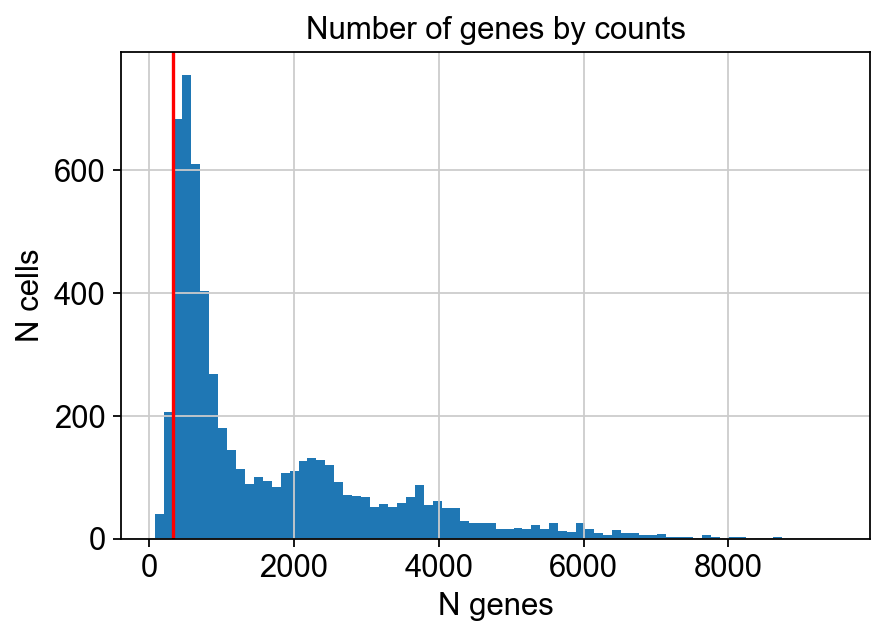

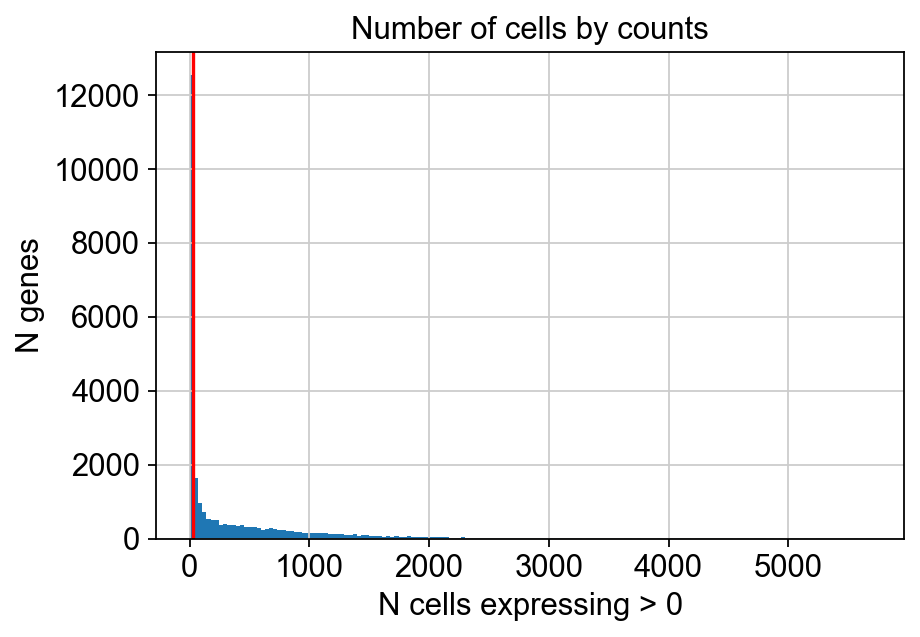

Saved genes_plot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_genes_plot.png
Saved cells_plot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_cells_plot.png
Genes plot and Cells plot were saved!
Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']
Annotated mitochondrial genes and calculated QC metrics.
Saved genes_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_violin_genes_counts.png
Saved total_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_violin_total_counts.png
Saved pct_counts_mt plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_violin_pct_counts_mt.png
Saved pct_mt_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_scatter_pct_mt.png
Saved genes_counts_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_scatter_genes_counts.png
Filtered cells based on gene counts with mt_analysis.
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:

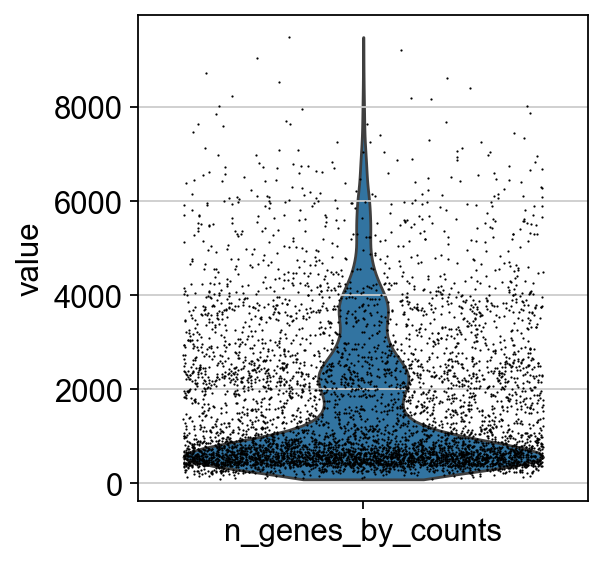

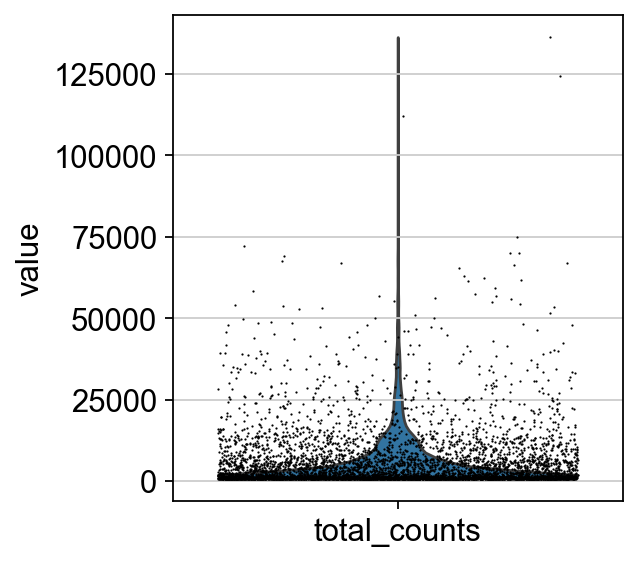

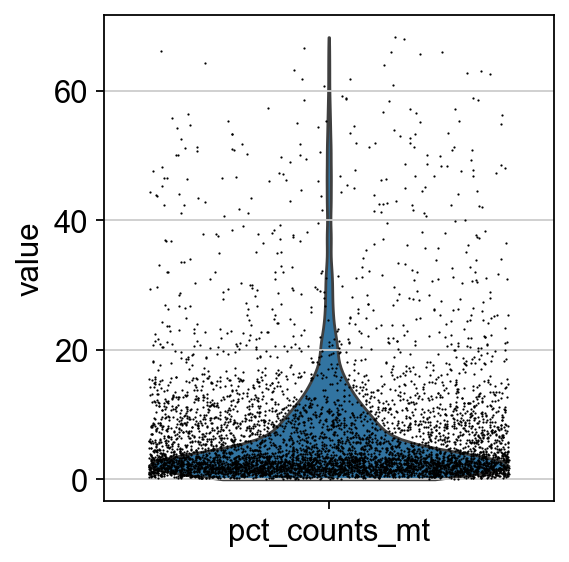

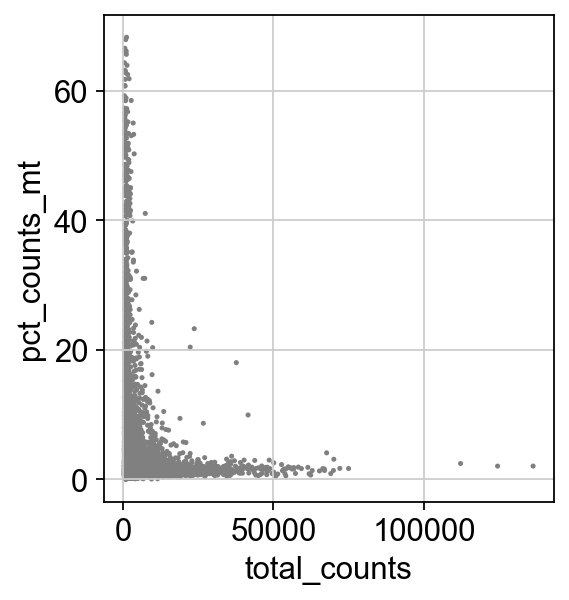

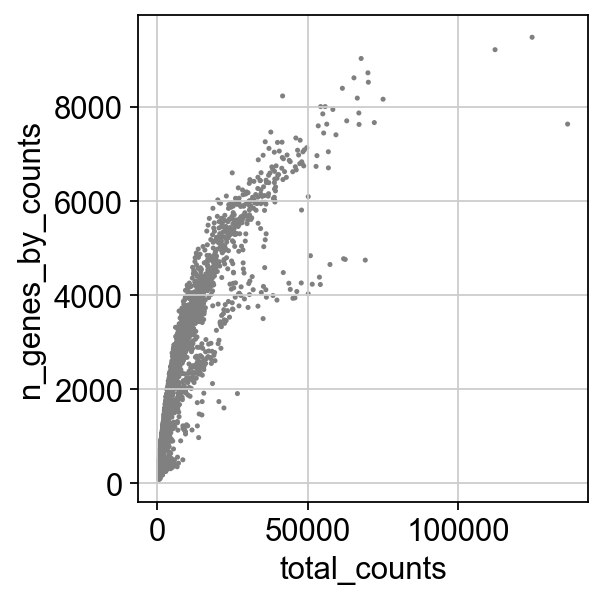

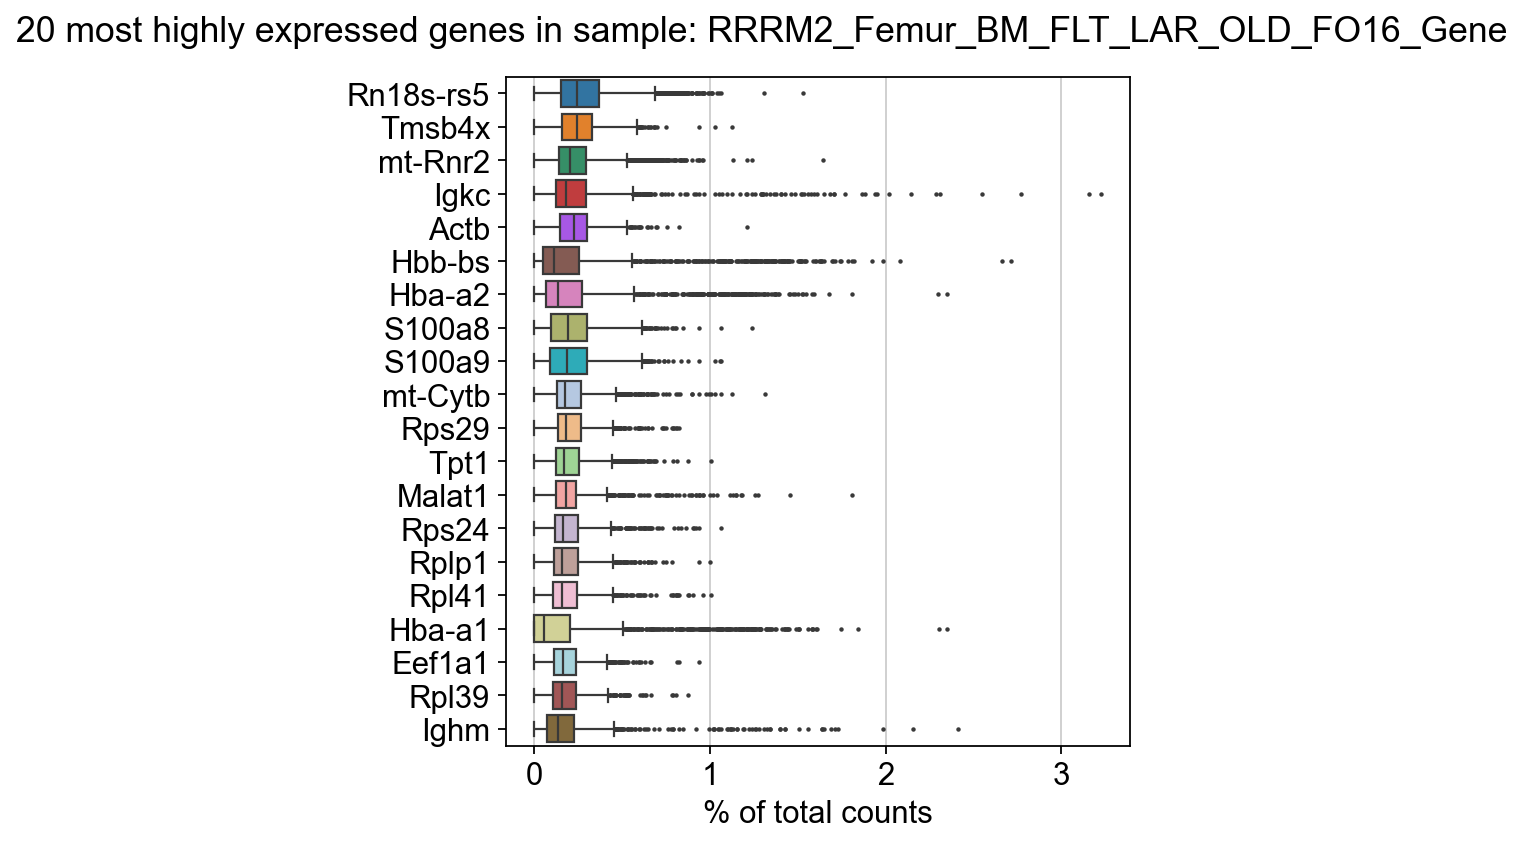

computing PCA
    with n_comps=50
    finished (0:00:01)
Saved PCAplot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_PCAplot.png


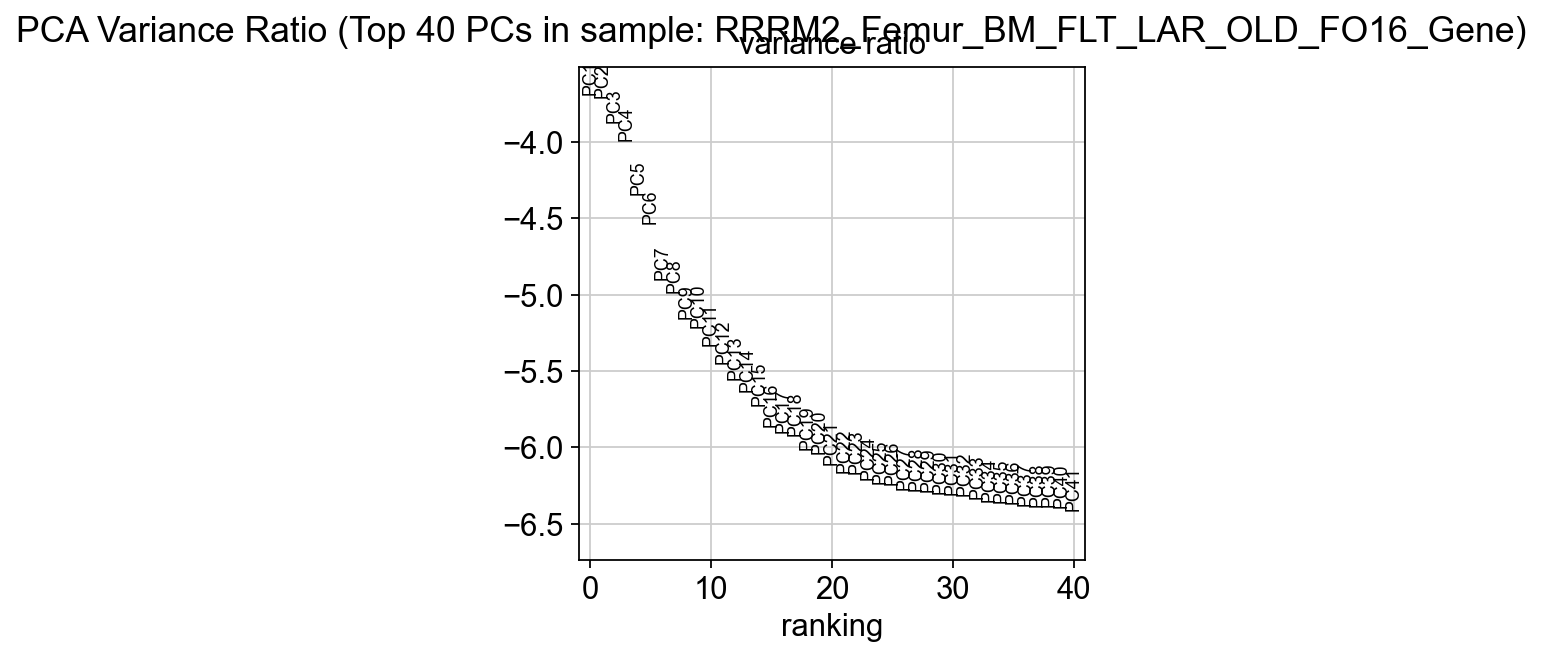

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  56748
Wrangling: Groups used for ranking: leide

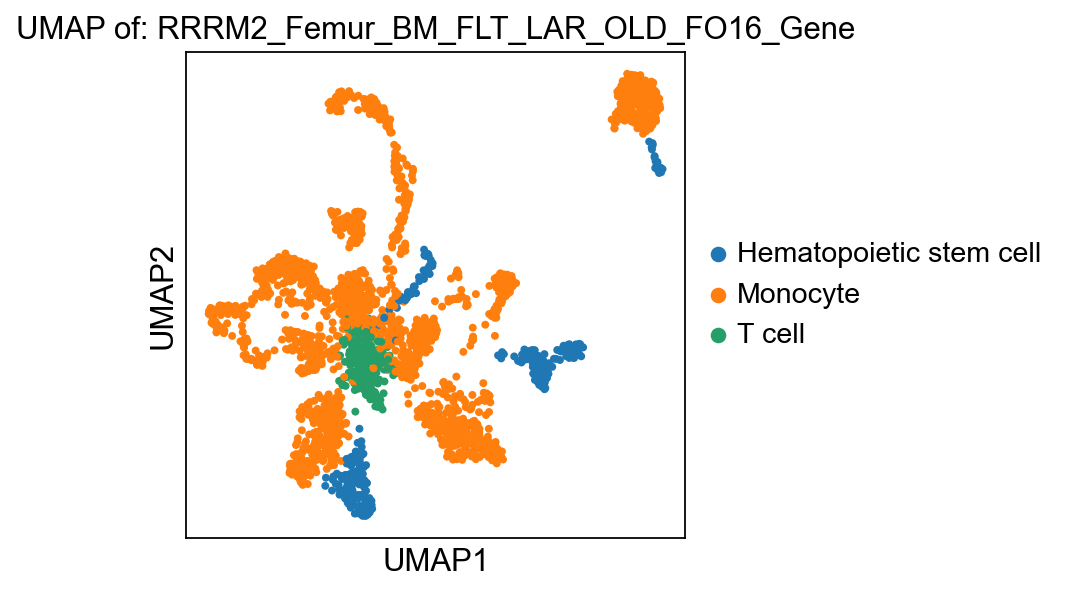

Finished processing RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene. Results saved to RRRM2_Femur_BM_FLT_LAR_OLD_FO16_Gene_results_scoreCT.h5ad

Processing directory: ./test\RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered
... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene-filtered-matrix.h5ad
Filter out cells expressing fewer than: 251.5 genes (5th percentile)
Filter out genes detected in fewer than: 26.97 cells (1th percentile)
Filtered data saved to RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_filtered.h5ad
Gene threshold: 251.5
Cell threshold: 26.97


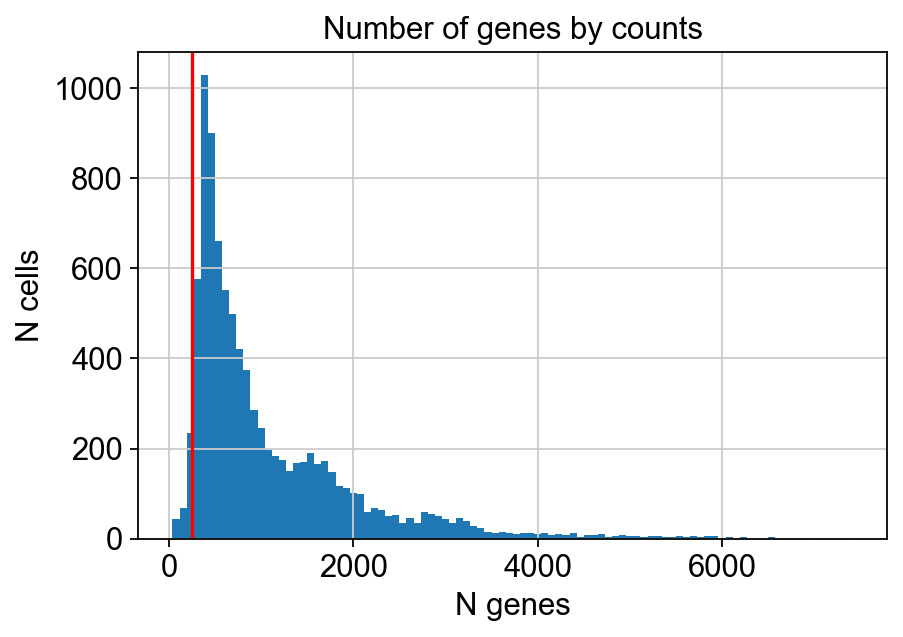

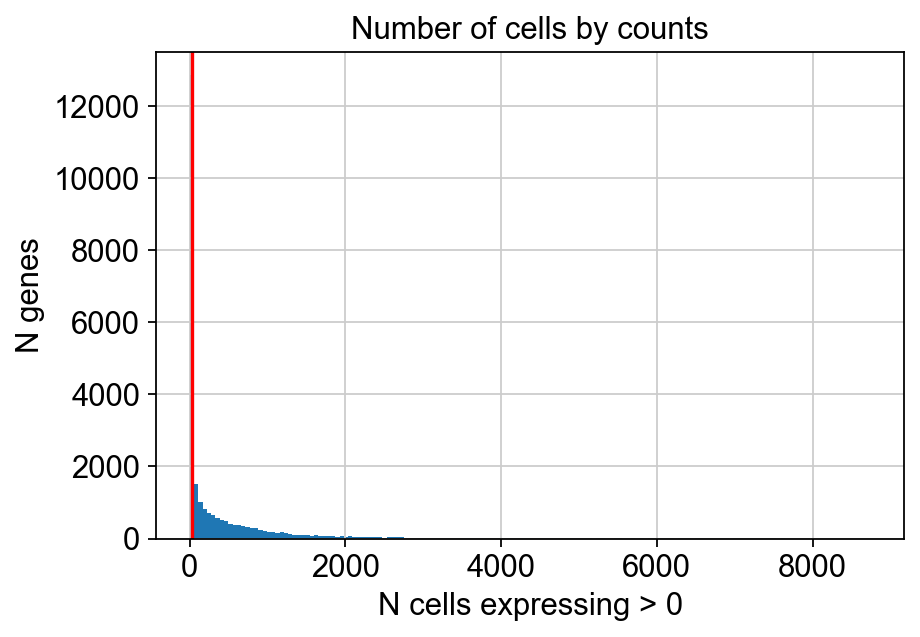

Saved genes_plot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_genes_plot.png
Saved cells_plot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_cells_plot.png
Genes plot and Cells plot were saved!
Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']
Annotated mitochondrial genes and calculated QC metrics.
Saved genes_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_genes_counts.png
Saved total_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_total_counts.png
Saved pct_counts_mt plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_pct_counts_mt.png
Saved pct_mt_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_scatter_pct_mt.png
Saved genes_counts_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_scatter_genes_counts.png
Filtered cells based on gene counts with mt_analysis.
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:

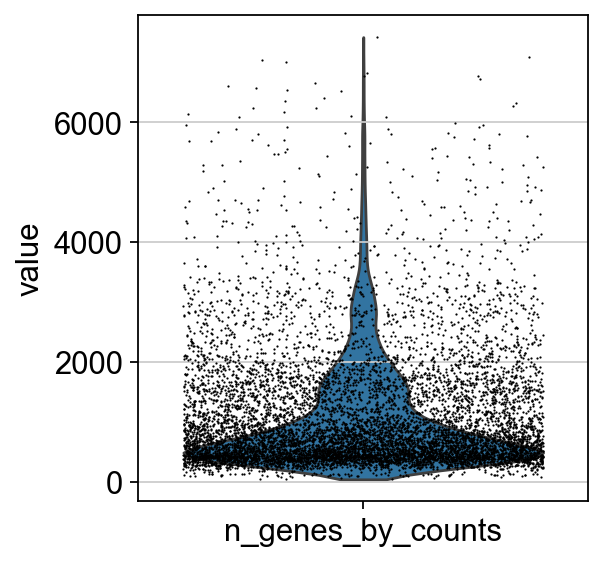

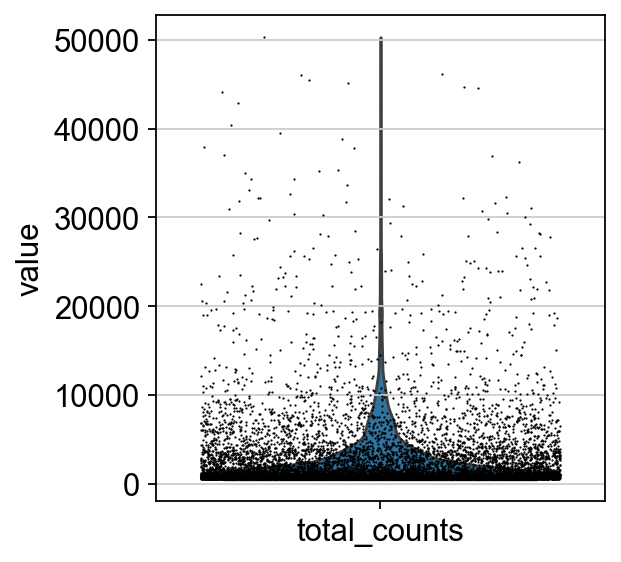

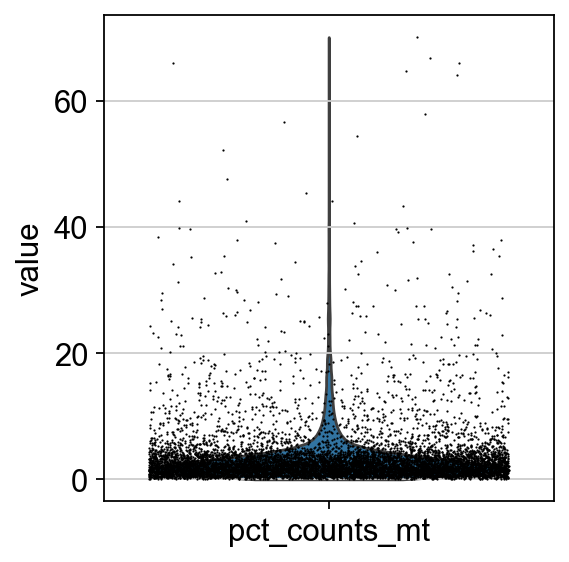

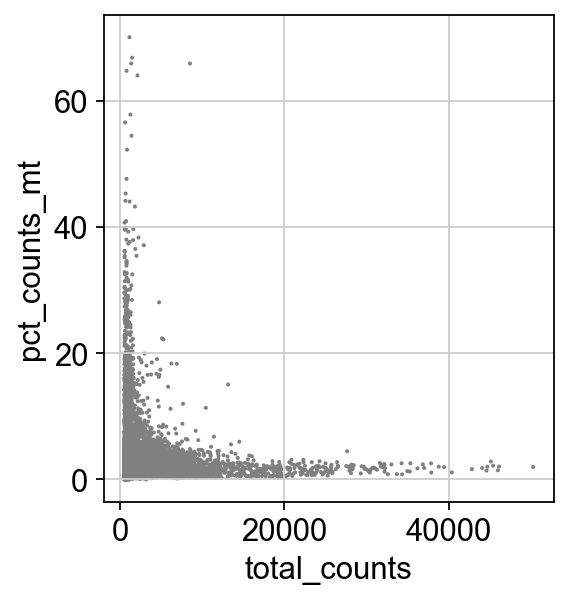

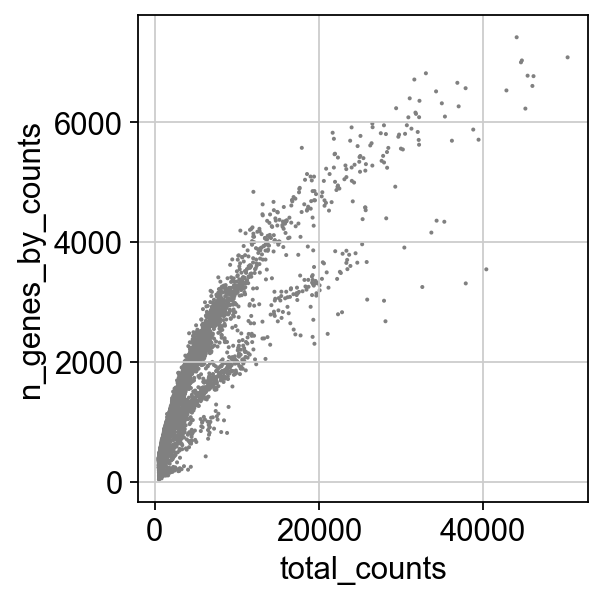

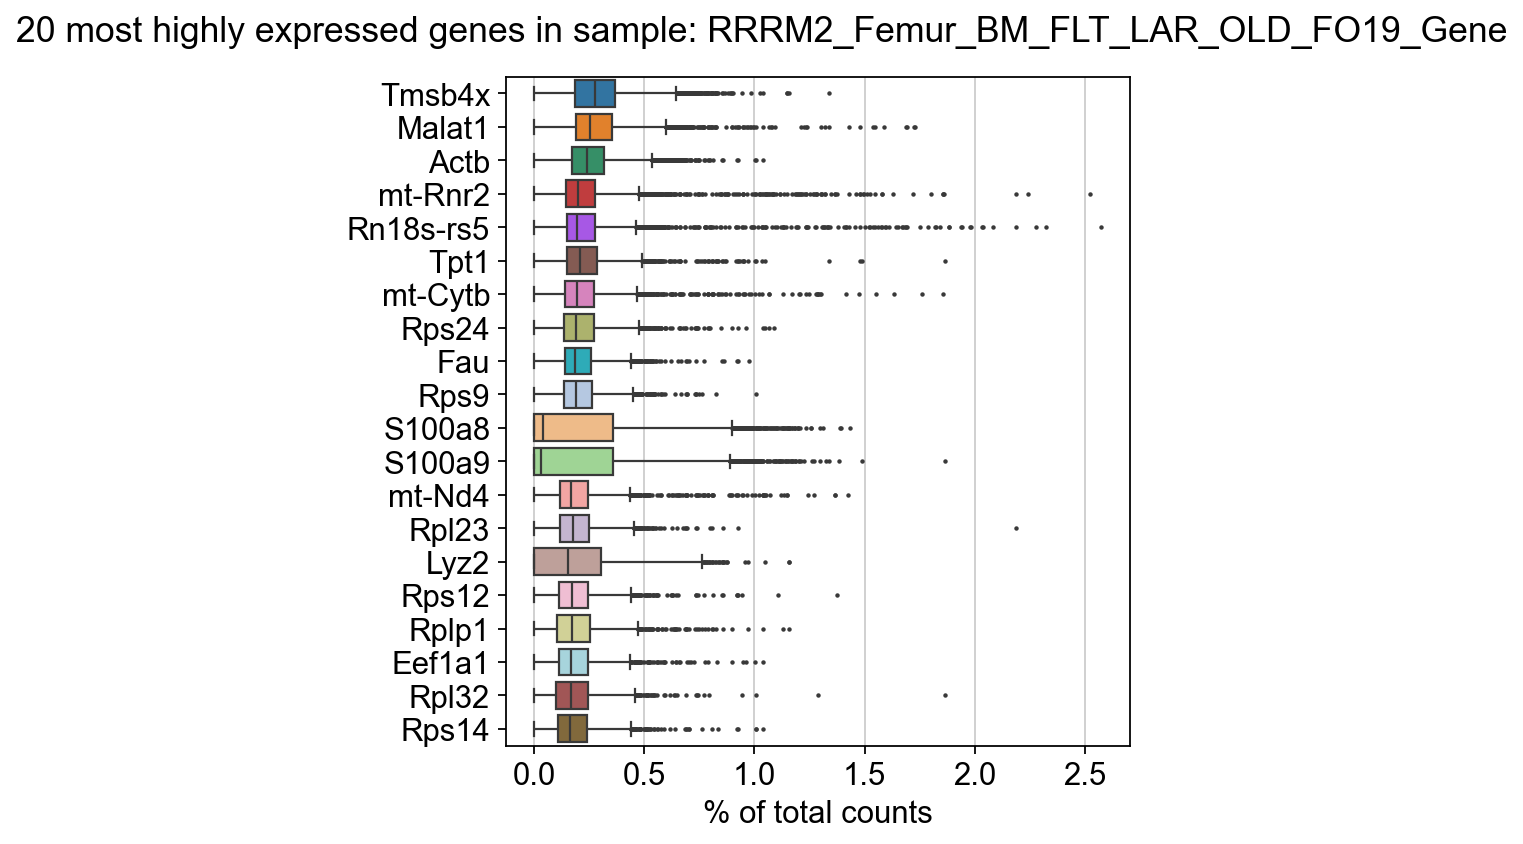

computing PCA
    with n_comps=50
    finished (0:00:01)
Saved PCAplot plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_PCAplot.png


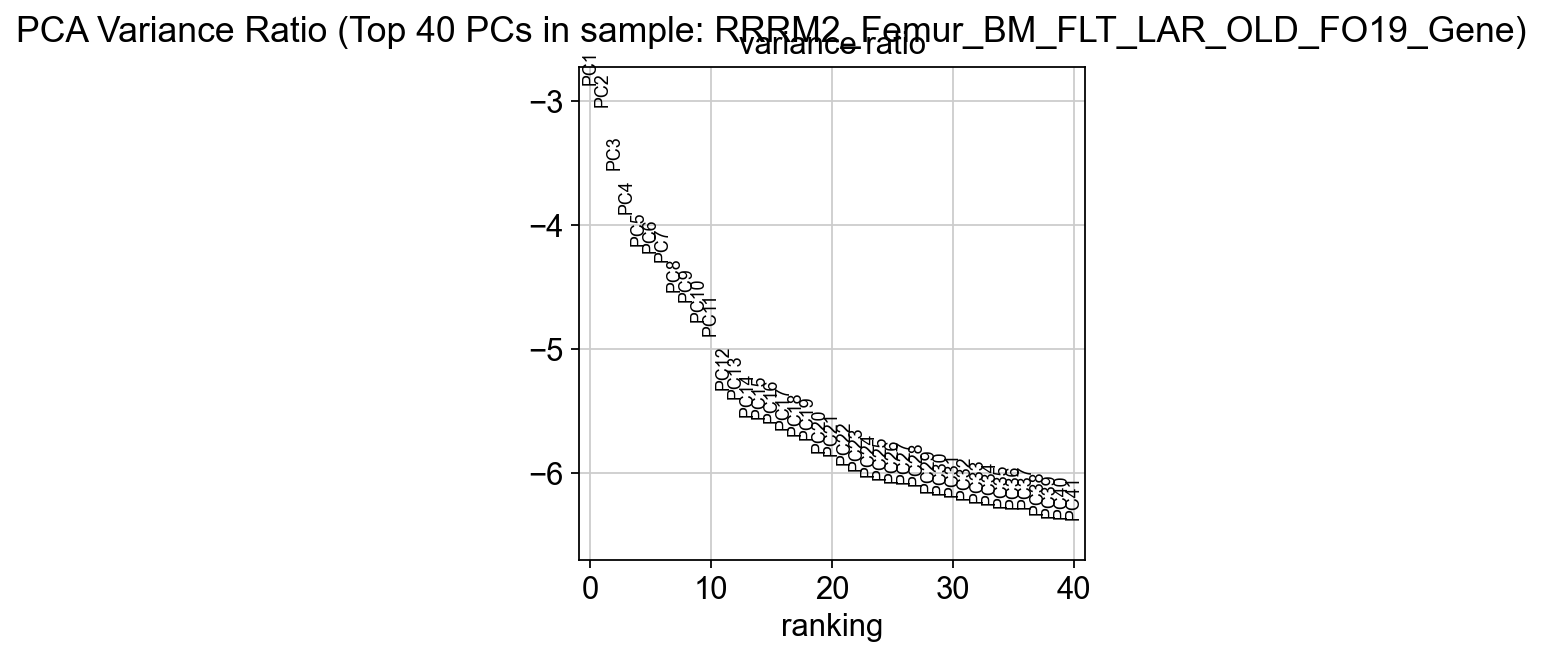

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:40)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  56748
Wrangling: Groups used for ranking: leide

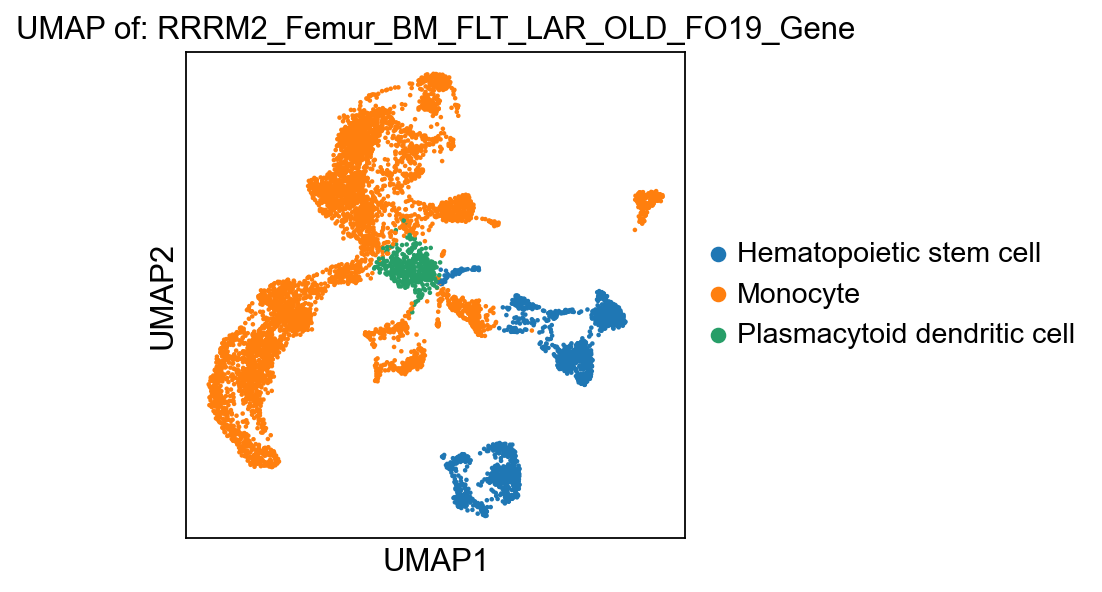

Finished processing RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene. Results saved to RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_results_scoreCT.h5ad



In [837]:
import os
import scanpy as sc

'''This script uses a loop to find all subdirectories
of working directory that contain scRNAseq datasets.
'''
#NOTE: file paths are hardcoded

#STEP 1: define paths 

base_path = './test'
marker_file = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.gmt'

#STEP 2: generate output folder structure:
Structure()

#STEP 3: Retrieve all input file paths and store them in a list:
#NOTE: It may crash when file structure will be different.
#NOTE: expected AnnData path is base_path/sample_name/filtered/
out = []
for root, dirs, files in os.walk(base_path):
    # it was a problem with catching invisible folders, fixed it:
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    # Check if the current directory matches the filtered path
    if 'filtered' in root.split(os.sep):
         out.append(root)
out

#STEP 4: Run Downstream analysis in a loop, until it process all data from "out" list:
for input_path in out:
    print(f"Processing directory: {input_path}")

    #STEP 4.1: Load AnnData as 10x_mtx:
    adata = sc.read_10x_mtx(input_path, var_names='gene_symbols', cache=True)

    #STEP 4.2: Define current sample name:
    #NOTE: sample name is retrieved from parent folder - it may crash when structure will be different
    sample_name = os.path.basename(os.path.dirname(input_path))

    #STEP 4.3: Define the results file based on sample name:
    results_file = f"{sample_name}_results_scoreCT.h5ad"

    # Module 4
    BasicFiltering(save_data=True)

    # Module 5
    plotCellsAndGenes(save_data=True)

    # Module 6
    mtAnalysis()

    # Module 7
    plotViolinScatter(save_data=True)

    # Module 8
    FilterCells()

    # Module 9
    Normalization(adata)
    RegressOut(adata)

    # Module 10
    plotPostNormalization(save_data=True)

    # Module 11
    plotPCA(save_data=True)

    # Module 12
    ClusterAnalysis()

    # Module 13
    ScoreCTAnnotation(save_data=True)

    # Module 14
    PlotUMAP("scoreCT", save_data=True)

    print(f"Finished processing {sample_name}. Results saved to {results_file}\n")


### Check processed AnnData and different genes:

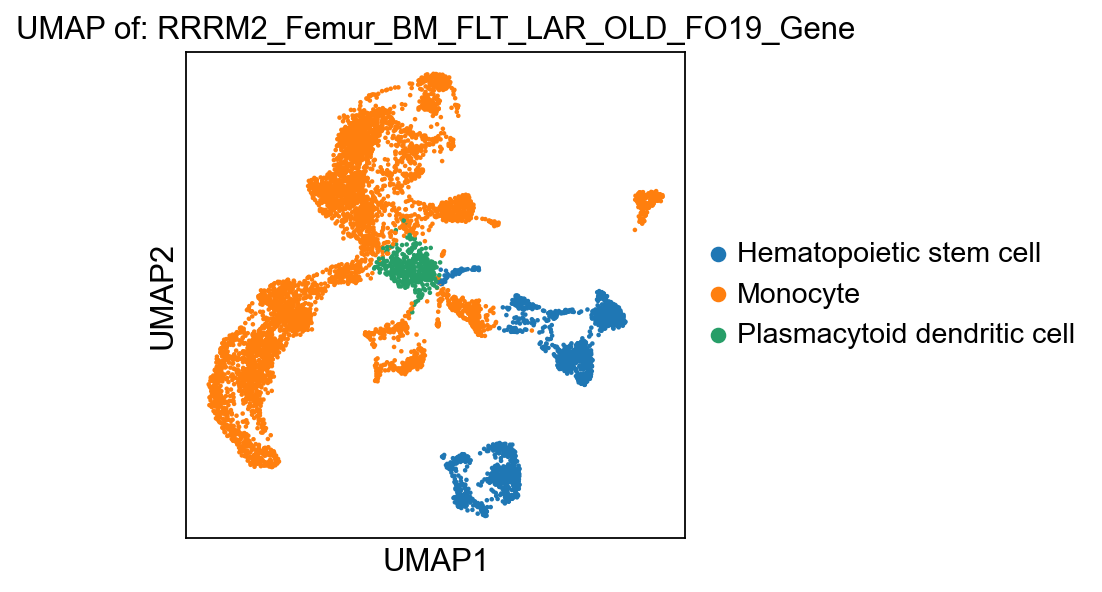

In [844]:
PlotUMAP("scoreCT")

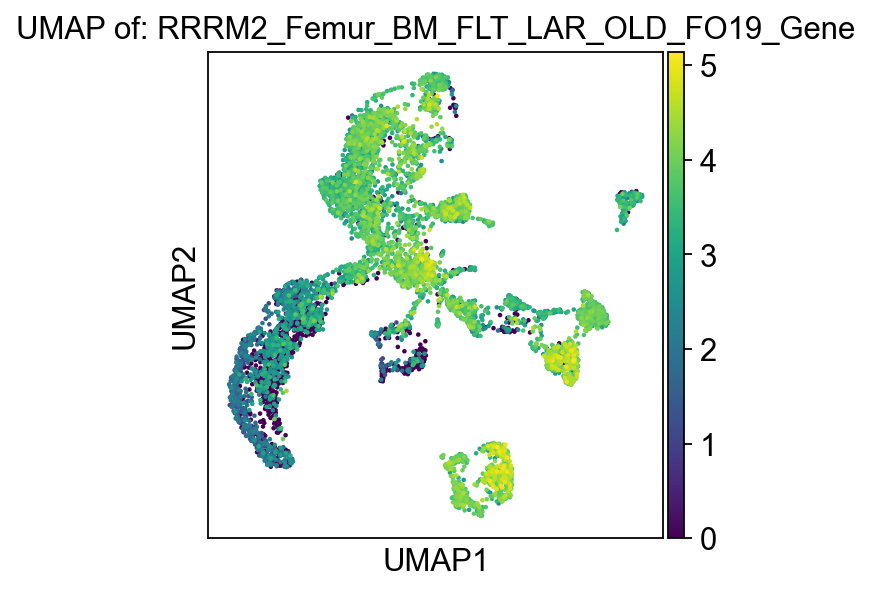

In [840]:
PlotUMAP("Rps14")

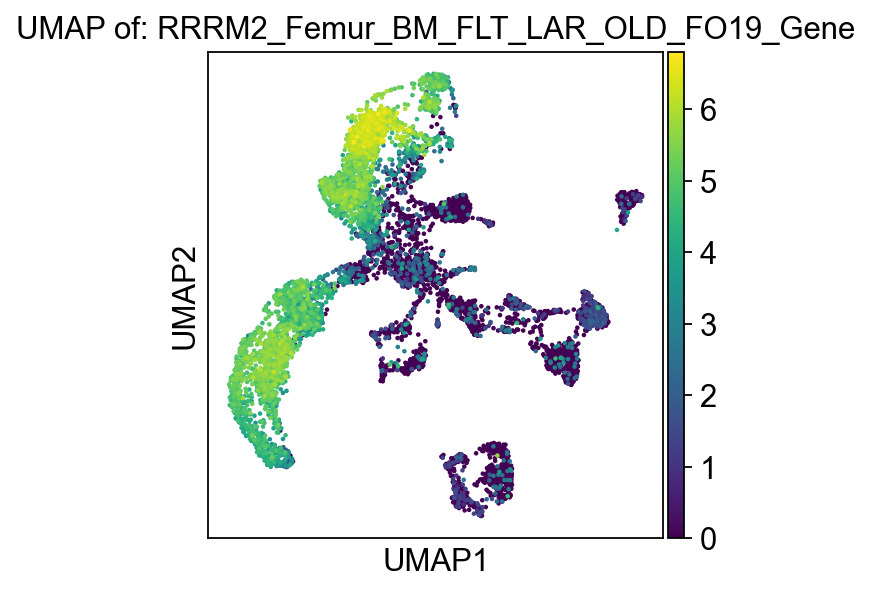

In [841]:
PlotUMAP("Lyz2")

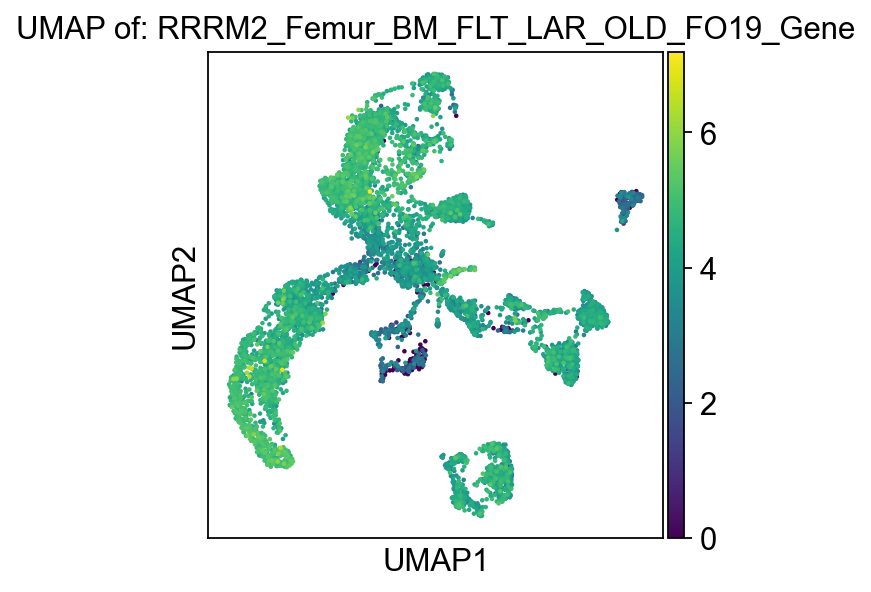

In [842]:
PlotUMAP("Actb")

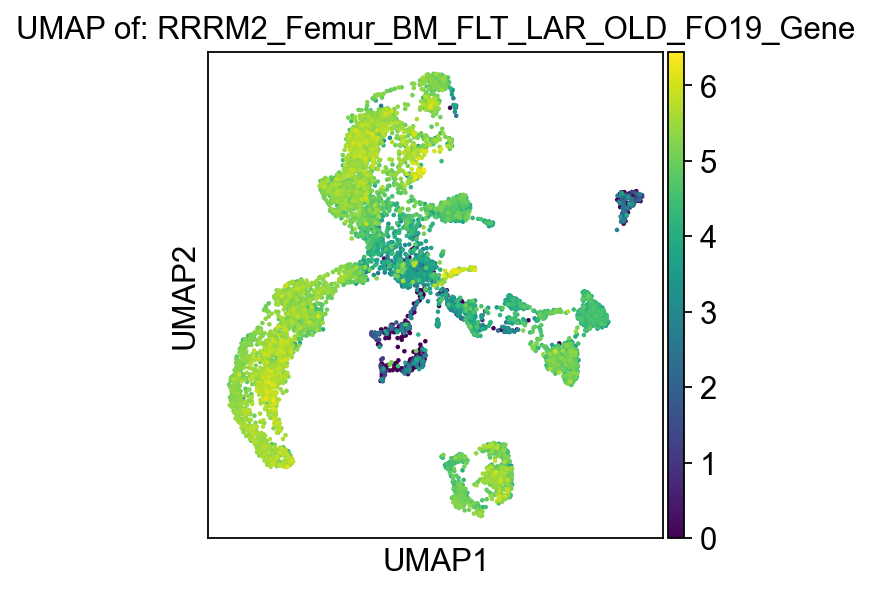

In [843]:
PlotUMAP("Tmsb4x")

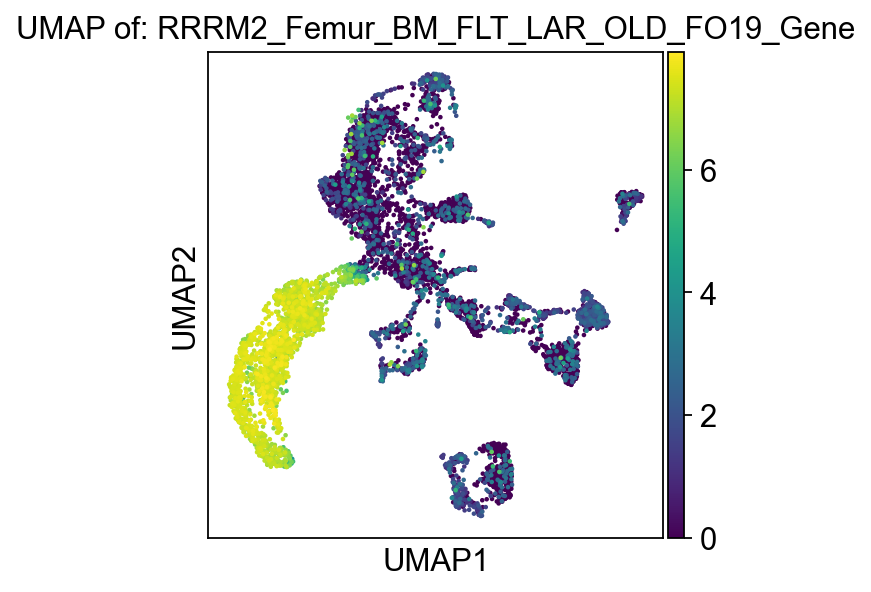

In [846]:
PlotUMAP("S100a9")